![](https://www.news-medical.net/image.axd?picture=2018%2F6%2Fshutterstock_582277528.jpg)

**Alzheimer's disease** is the most common type of dementia. It is a progressive disease beginning with mild memory loss and possibly leading to loss of the ability to carry on a conversation and respond to the environment. Alzheimer's disease involves parts of the brain that control thought, memory, and language.

# **Importing libraries**

In [38]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# **Identify dataset**

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/adni-extracted-axial/Axial",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/adni-extracted-axial/Axial",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5154 files belonging to 3 classes.
Using 4124 files for training.
Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [40]:
# number and names of Classes
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(3, ['AD', 'CI', 'CN'])

# **Data Visualization**

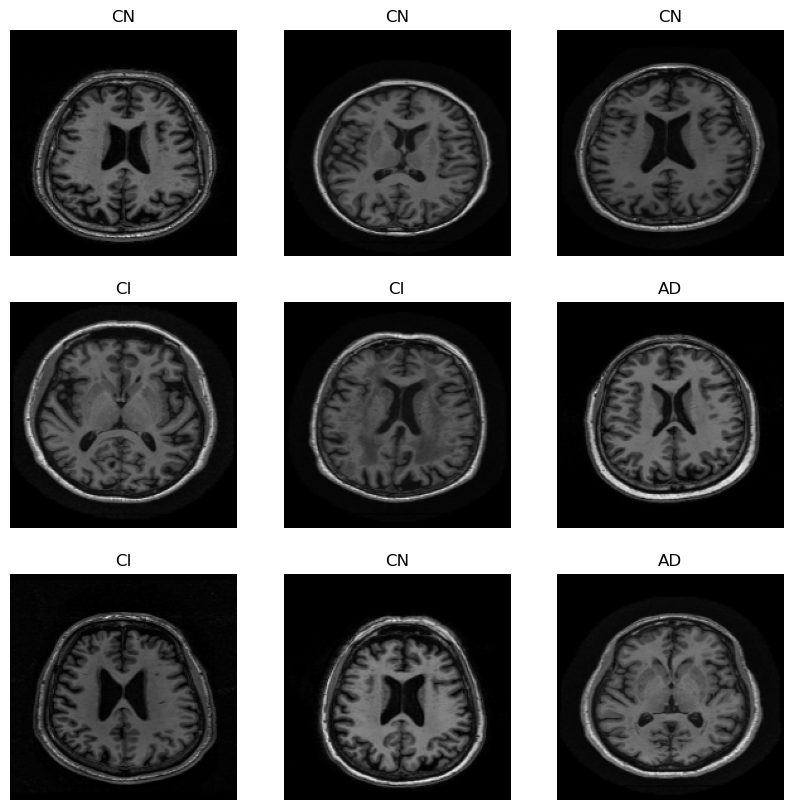

In [41]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [42]:
# Number of images in each class
NUM_IMAGES = []

for label in classnames:
    dir_name = "/kaggle/input/adni-extracted-axial/Axial" +'/'+ label 
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))
    
NUM_IMAGES,classnames

([1124, 2590, 1440], ['AD', 'CI', 'CN'])

In [43]:
# Rename class names
class_names = ['Alzheimer Disease', 'Cognitively Impaired', 'Cognitively Normal']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)
NUM_CLASSES

3

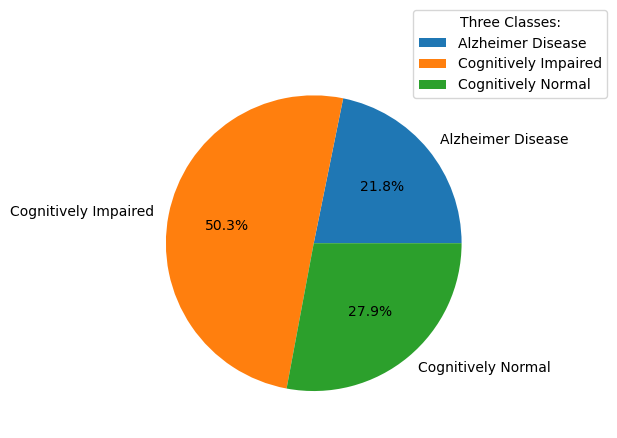

In [44]:
# Before Oversampling
# Visualization of each class with pie chart
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(NUM_IMAGES, autopct='%1.1f%%',labels=train_ds.class_names)
plt.legend(title = "Three Classes:",bbox_to_anchor =(0.75, 1.15))

In [45]:
# Performing Image Augmentation to have more data samples
IMG_SIZE = 180
IMAGE_SIZE = [180, 180]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="/kaggle/input/adni-extracted-axial/Axial"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=8000, shuffle=False)

Found 5154 images belonging to 3 classes.


In [46]:
train_data, train_labels = train_data_gen.next()

# **Oversampling technique**

![](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/How-to-Deal-With-Imbalanced-Classification-and-Regression-Data_24.png?resize=763%2C403&ssl=1)

In [47]:
# Shape of data before oversampling
print(train_data.shape, train_labels.shape)

(5154, 180, 180, 3) (5154, 3)


In [48]:
# Performing over-sampling of the data, since the classes are imbalanced
# After oversampling using SMOTE
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(7770, 180, 180, 3) (7770, 3)


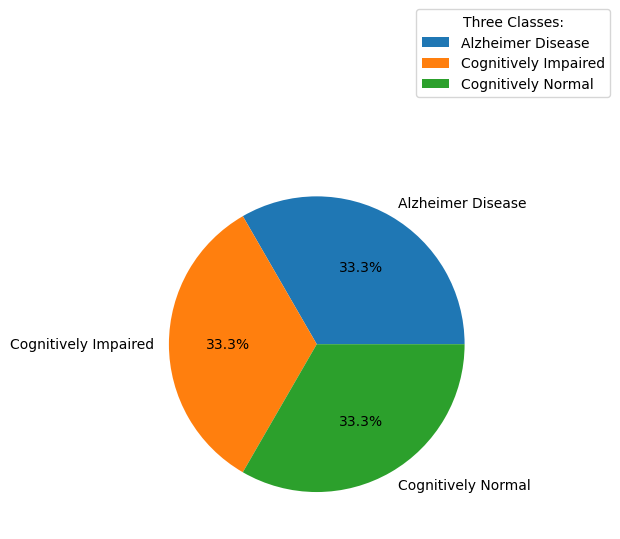

In [49]:
# Show pie plot for dataset (after oversampling)
# Visualization of each class with pie chart
images_after = [2590,2590,2590]
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.pie(images_after, autopct='%1.1f%%',labels=train_ds.class_names)
plt.legend(title = "Three Classes:",bbox_to_anchor =(0.75, 1.15))

# **Spliting data**

In [50]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# **Building the model**

In [51]:
#-------VGG16--------

vgg = VGG16(input_shape=(180,180,3),weights='imagenet',include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input,outputs=prediction)

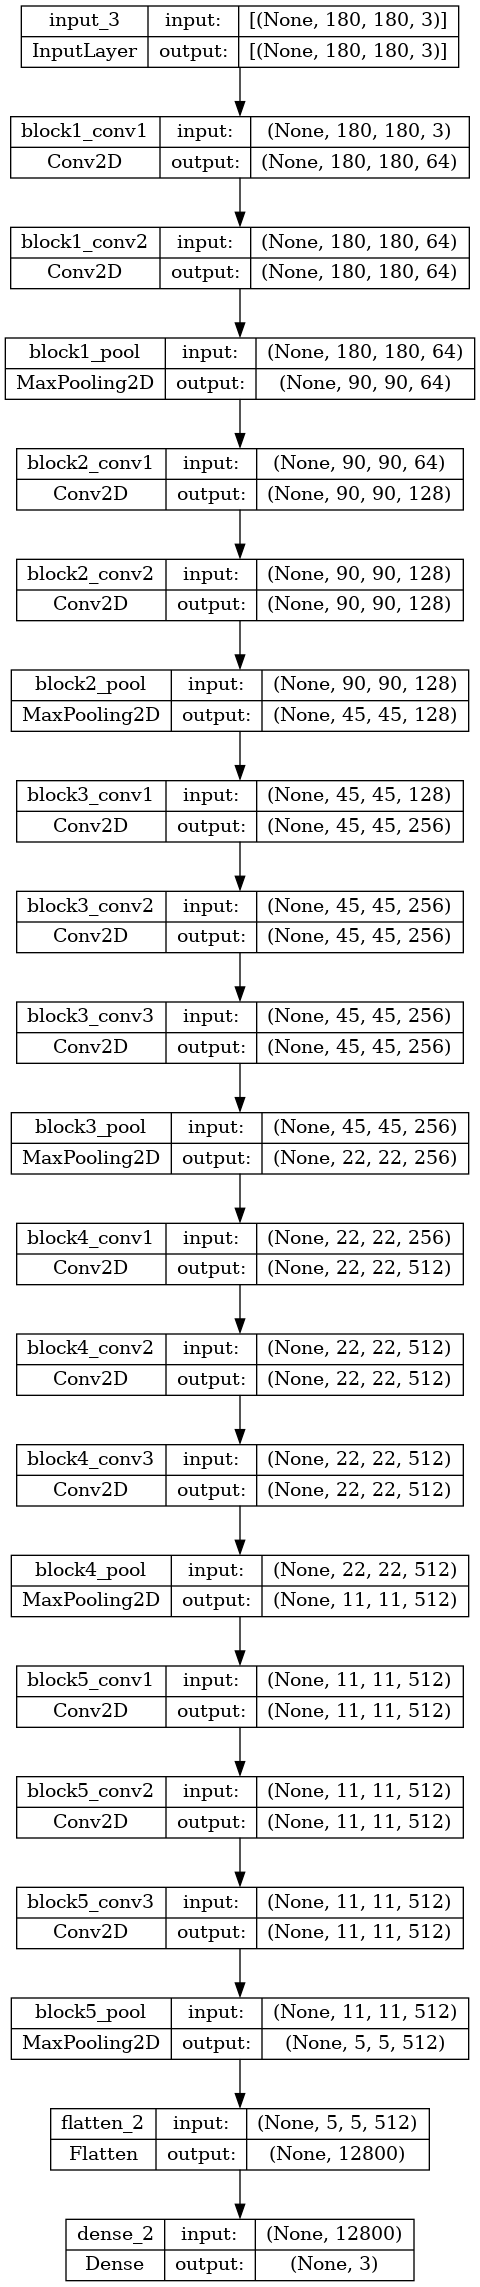

In [52]:
# Plotting layers as an image
plot_model(modelvgg,to_file="alzahimer.png",show_shapes=True)

In [53]:
# Optimizing model
modelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# **Training model using my data**

In [54]:
# Fitting the model
hist = modelvgg.fit(
           train_data, train_labels,
           epochs=15,validation_data=(val_data, val_labels), 
            callbacks=[checkpoint, lr_reduce])

Epoch 1/15
156/156 [==============================] - 11s 67ms/step - loss: 0.8797 - accuracy: 0.5959 - val_loss: 0.6770 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 2/15
156/156 [==============================] - 9s 60ms/step - loss: 0.5900 - accuracy: 0.7673 - val_loss: 0.5136 - val_accuracy: 0.8119 - lr: 0.0010
Epoch 3/15
155/156 [============================>.] - ETA: 0s - loss: 0.4585 - accuracy: 0.8500
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
156/156 [==============================] - 9s 61ms/step - loss: 0.4588 - accuracy: 0.8500 - val_loss: 0.4537 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 4/15
156/156 [==============================] - 9s 60ms/step - loss: 0.3702 - accuracy: 0.9093 - val_loss: 0.4071 - val_accuracy: 0.8794 - lr: 3.0000e-04
Epoch 5/15
155/156 [============================>.] - ETA: 0s - loss: 0.3513 - accuracy: 0.9121
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
156/156 [=============================

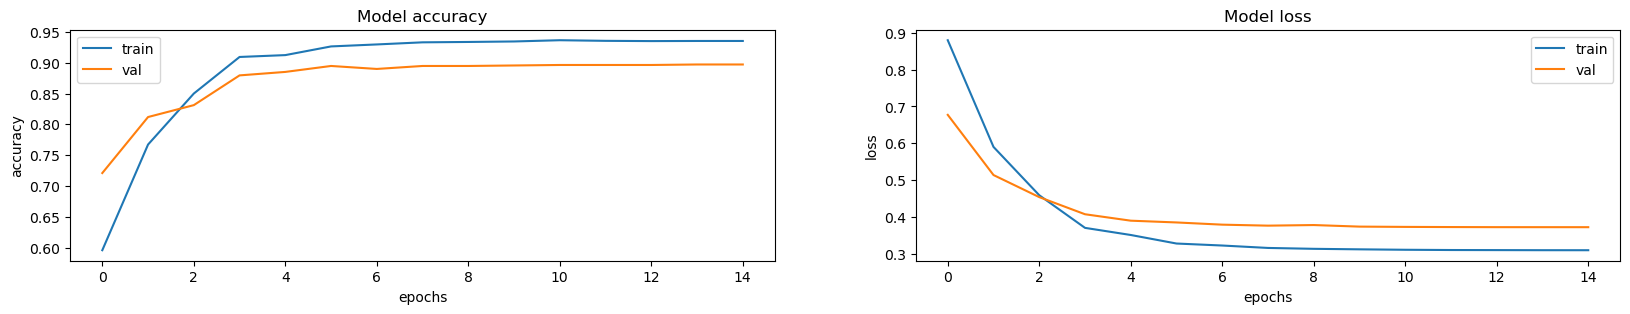

In [55]:
# Plotting accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [56]:
# Evaluation using test data
test_scores = modelvgg.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

49/49 [==============================] - 2s 46ms/step - loss: 0.3689 - accuracy: 0.8880
Testing Accuracy: 88.80%


In [57]:
pred_labels = modelvgg.predict(test_data)

49/49 [==============================] - 2s 43ms/step


# **Confusion matrix**

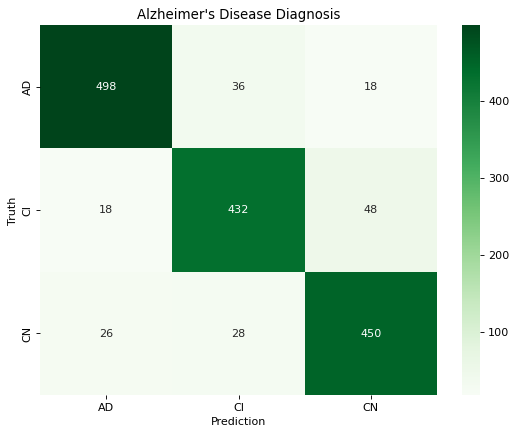

In [58]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

# **Classification report**

In [59]:
print(classification_report(test_ls, pred_ls, target_names=classnames))

              precision    recall  f1-score   support

          AD       0.92      0.90      0.91       552
          CI       0.87      0.87      0.87       498
          CN       0.87      0.89      0.88       504

    accuracy                           0.89      1554
   macro avg       0.89      0.89      0.89      1554
weighted avg       0.89      0.89      0.89      1554



# **Save the model for a Mobile app as tflite**

In [60]:
export_dir = '/kaggle/working/'
tf.saved_model.save(modelvgg, export_dir)
tflite_model_name = "alzheimerfinaly.tflite"
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [61]:
tflite_model_file = pathlib.Path(tflite_model_name)
tflite_model_file.write_bytes(tflite_model)

14825944

# **Save the model for a Web app as hdf5**

In [62]:
tf.keras.models.save_model(modelvgg,'Alzheimer_finaly.hdf5')

# **Conclusion**

![](https://blog.vantagecircle.com/content/images/2021/06/Employee-Recognition.png)

**That's all for my notebook.. I hope this benefit for everyone..**

![](https://c4.wallpaperflare.com/wallpaper/787/255/786/vault-boy-fallout-fallout-3-video-games-wallpaper-preview.jpg)